In [1]:
import numpy as np
import torch
from torch import optim
from tqdm.autonotebook import tqdm
from torch import distributions as dist
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from IPython import display
from time import sleep
import pandas as pd
import seaborn as sns
import optuna

from simulate.simulate import simulate

from inference.plannar import NormalizingFlow
from inference.loss import LossTeaching

from plot.plot_hist_loss import plot_loss
from plot.plot_posterior import plot_posterior
from plot.loss_tracker import LossTracker

In [2]:
%config InlineBackend.figure_format = "retina"
sns.set()

In [3]:
class LossMinibatch:
    @staticmethod
    def __call__(z_flow, theta_flow, n_sample, n_u, n_w, 
                 u, w, x, r, y):
        
        # Get unique users for this (mini)batch
        uniq_u = np.unique(u)
        uniq_w = np.unique(w)
        
        # Z: Sample base distribution and apply transformation
        z0_Z = z_flow.sample_base_dist(n_sample)
        zk_Z, ln_q0_Z, log_det_Z = z_flow(z0_Z)
        
        # θ: Sample base distribution and apply transformation
        z0_θ = theta_flow.sample_base_dist(n_sample)
        zk_θ, ln_q0_θ, log_det_θ = theta_flow(z0_θ)
        
        # Compute sum of log determinants over flow_length
        sum_ld_Z = log_det_Z.sum(axis=0).squeeze()
        sum_ld_θ = log_det_θ.sum(axis=0).squeeze()
        
        # Get Z-values used for first parameter
        Zu1 = zk_Z[:, :n_u].T
        Zw1 = zk_Z[:, n_u:n_w + n_u].T

        # Get Z-values used for second first parameter
        Zu2 = zk_Z[:, n_w + n_u:n_w + n_u * 2].T
        Zw2 = zk_Z[:, n_w + n_u * 2:].T
        
        # Get θ-values for both parameters
        mu1, log_var_u1, log_var_w1 = zk_θ[:, :3].T
        mu2, log_var_u2, log_var_w2 = zk_θ[:, 3:].T
        
        # Compute Z-values for both parameters
        Z1 = Zu1[u] + Zw1[w]
        Z2 = Zu2[u] + Zw2[w]
        
        # Go to constrained space
        param1 = torch.exp(Z1)
        param2 = torch.sigmoid(Z2)
        
        # Compute log probability of recall
        log_p = -param1 * x * (1 - param2) ** r
        
        # Comp. likelihood of observations
        ll = dist.Bernoulli(probs=torch.exp(log_p)).log_prob(y).sum(axis=0)
        
        # Comp. likelihood Z-values given population parameterization for first parameter
        ll_Zu1 = dist.Normal(mu1, torch.exp(0.5 * log_var_u1)).log_prob(Zu1[uniq_u]).sum(axis=0)
        ll_Zw1 = dist.Normal(mu1, torch.exp(0.5 * log_var_w1)).log_prob(Zw1[uniq_w]).sum(axis=0)
        
        # Comp. likelihood Z-values given population parameterization for second parameter
        ll_Zu2 = dist.Normal(mu2, torch.exp(0.5 * log_var_u2)).log_prob(Zu2[uniq_u]).sum(axis=0)
        ll_Zw2 = dist.Normal(mu2, torch.exp(0.5 * log_var_w2)).log_prob(Zw2[uniq_w]).sum(axis=0)
        
        # Add all the loss terms and compute average (= expectation estimate)
        to_min = (ln_q0_Z + ln_q0_θ
                  - sum_ld_Z - sum_ld_θ
                  - ll - ll_Zu1 - ll_Zu2 - ll_Zw1 - ll_Zw2).mean()
        return to_min

In [34]:
def train(   
        data,
        n_epochs=5000,
        initial_lr=0.01,
        flow_length=16,
        n_sample=40,
        batch_size=None,
        constant_lr=False,
        optimizer_name="Adam"):
    
    n_u = len(np.unique(data['u']))
    n_w = len(np.unique(data['w']))
    n_obs = len(data['u'])
    
    if batch_size is None:
        batch_size = n_obs

    z_flow = NormalizingFlow(dim=(n_u + n_w) * 2, flow_length=flow_length)
    theta_flow = NormalizingFlow(6, flow_length=flow_length)

    optimizer = getattr(optim, optimizer_name)(
        list(z_flow.parameters()) + list(theta_flow.parameters()),
        lr=initial_lr)

    loss_func = LossMinibatch()
    
    hist_loss = []

    indices = np.arange(n_obs)

    for epoch in tqdm(range(n_epochs)):

        np.random.shuffle(indices)

        for i in range(0, n_obs, batch_size):

            idx_minibatch = indices[i:i+batch_size]

            d = {k: v[idx_minibatch] for k, v in data.items()}

            optimizer.zero_grad()
            loss = loss_func(z_flow=z_flow,
                             theta_flow=theta_flow,
                             n_sample=n_sample,
                             n_u=n_u, n_w=n_w,
                             **d)
            loss.backward()
            optimizer.step()

            hist_loss.append(loss.item())
            
            if constant_lr:
                for g in optimizer.param_groups:
                    g['lr'] = initial_lr
    return z_flow, theta_flow, hist_loss

In [35]:
data_dict, truth = simulate()
data = {
    'x': torch.from_numpy(data_dict['x'].reshape(-1, 1)), 
    'y': torch.from_numpy(data_dict['y'].reshape(-1, 1)), 
    'r': torch.from_numpy(data_dict['r'].reshape(-1, 1)), 
    'u': data_dict['u'], 
    'w': data_dict['w']}

In [37]:
z_flow, theta_flow, hist_loss = train(data, batch_size=1000, n_epochs=10,
                                     constant_lr=True)

  0%|          | 0/10 [00:00<?, ?it/s]

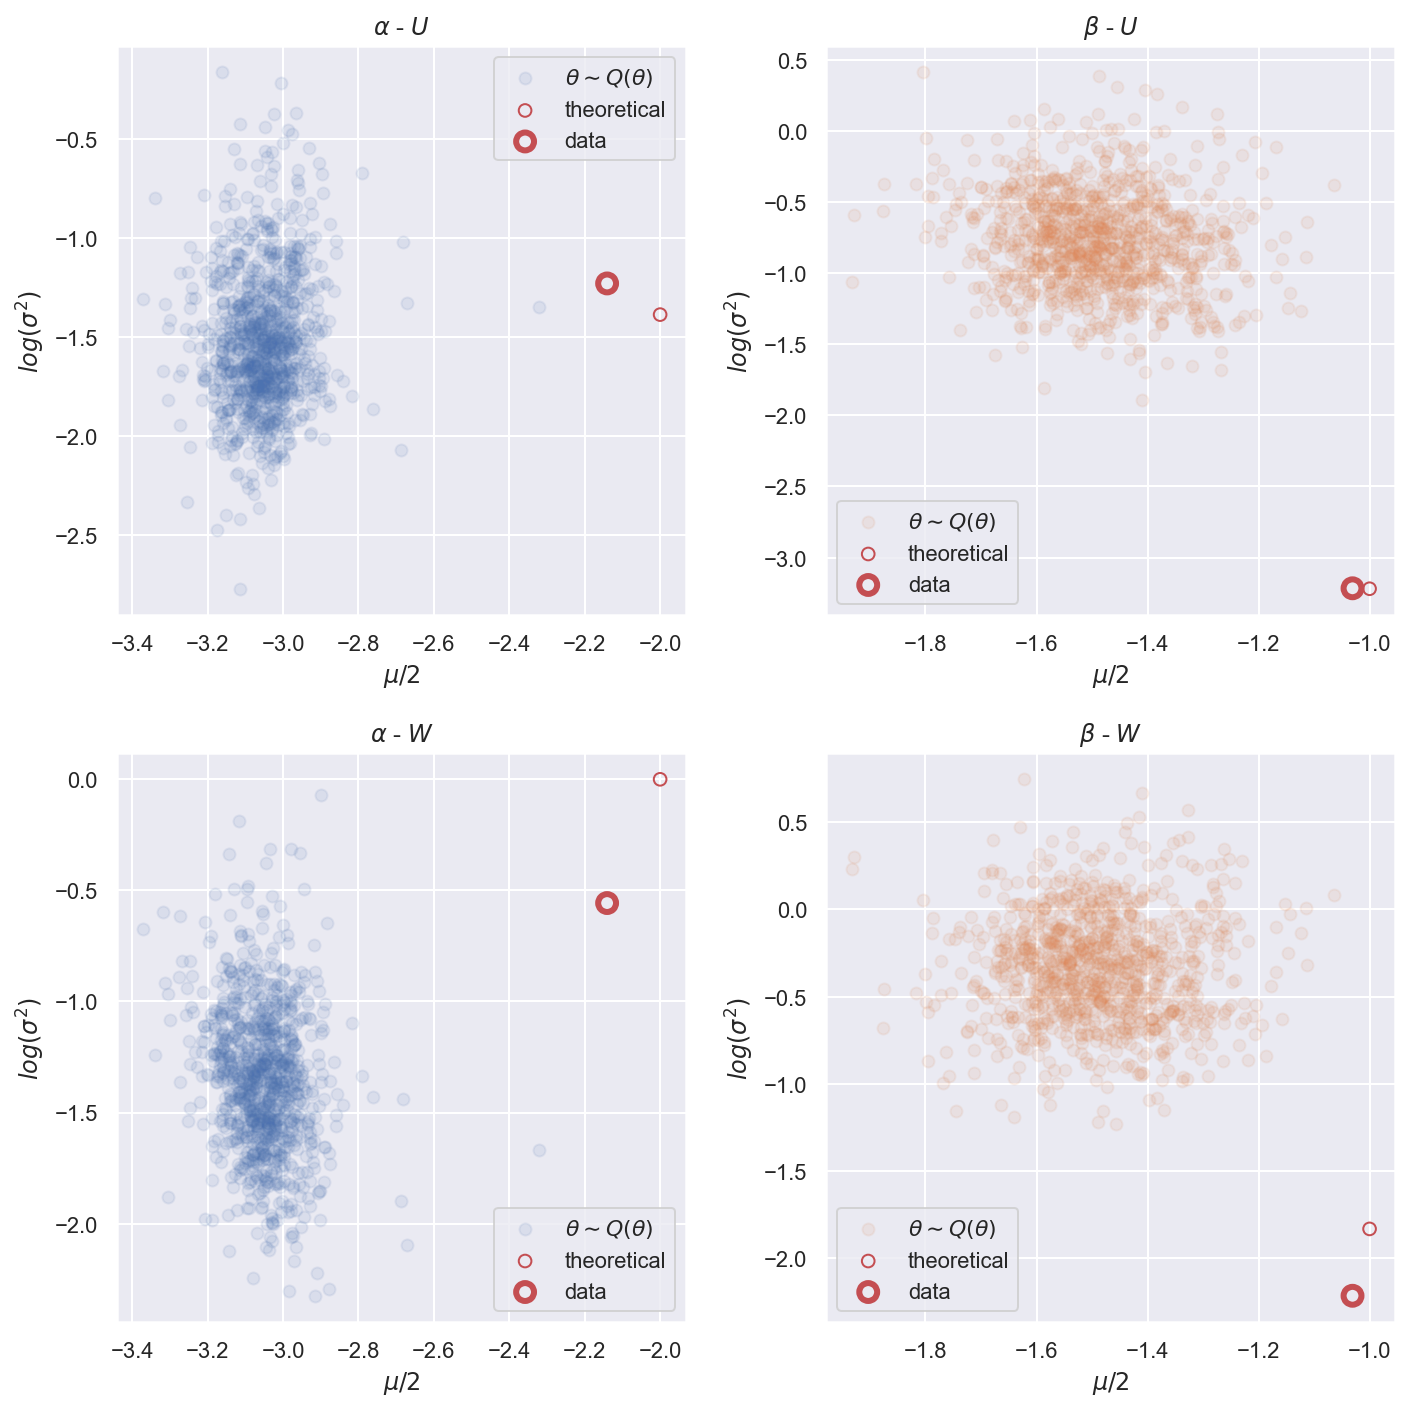

In [38]:
plot_posterior(theta_flow=theta_flow, 
               truth=truth, 
               name='artificial_mini_batch')

In [39]:
data_dict, truth = simulate()
DATA = {
    'x': torch.from_numpy(data_dict['x'].reshape(-1, 1)), 
    'y': torch.from_numpy(data_dict['y'].reshape(-1, 1)), 
    'r': torch.from_numpy(data_dict['r'].reshape(-1, 1)), 
    'u': data_dict['u'], 
    'w': data_dict['w']}

In [44]:
def objective(trial):

    n_epochs = 100
    initial_lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    flow_length = trial.suggest_int("flow_length", 1, 40)
    n_sample = trial.suggest_int("n_sample", 1, 100)
    batch_size = 1000
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    constant_lr = trial.suggest_categorical("constant_lr", [True, False])
    
    z_flow, theta_flow, hist_loss = train(
        DATA, batch_size=batch_size, n_epochs=n_epochs,
        flow_length=flow_length, initial_lr=initial_lr)
    
    loss = LossTeaching()(
        z_flow=z_flow,
        theta_flow=theta_flow,
        n_sample=100,
        n_u=len(np.unique(DATA['u'])), 
        n_w=len(np.unique(DATA['w'])),
        **DATA).item()

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

study.best_params

[I 2021-05-31 18:20:42,216] A new study created in memory with name: no-name-298fa1d3-9576-4214-adb0-2ceee898a98d


  0%|          | 0/100 [00:00<?, ?it/s]